# Controllable Text Summarization via Prompt Injection

Guiding LLMs to generate summaries of specific lengths and format (e.g., five sentences, 280 words, bullet list) poses a considerable challenge. This study seeks to experiment with prompt injection strategies aimed at directing LLMs towards fulfilling user-requested summary accurately.

Prompt injection is a technique that involves adding a prompt to the input of a language model to guide its output. The prompt can be a sentence, a paragraph, or a set of instructions that the model should follow. In this study, we will experiment with different prompt injection strategies to guide the model to generate summaries of specific lengths and formats.

We mainly focus on the following prompt injection strategies:

Reasoning-based prompts: 
-   Generate a text {10-20-30} times shorter
-   Generate a text of length e•ln^2 w.r.t. the number of words in the document

Instruction-based prompts:
-   Generate a summary of {50-75-100-125-150-175-200} words
-   Generate a 1-sentence summary
-   Generate a bullet point of 3-5-10 items summarizing the document

#### Imports and library installations:

In [1]:
!pip install wandb
!pip3 install --upgrade transformers optimum
# If using PyTorch 2.1 + CUDA 12.x:
!pip3 install --upgrade auto-gptq

  Obtaining dependency information for optimum from https://files.pythonhosted.org/packages/5d/7a/1cc655edf289cdb533b0ea1d2f382d344248a53ad21eb8e34deb4551684b/optimum-1.17.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/407.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/407.1 kB ? eta -:--:--
   ---------------- ----------------------- 163.8/407.1 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 407.1/407.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: optimum
    Found existing installation: optimum 1.17.0
    Uninstalling optimum-1.17.0:
      Successfully uninstalled optimum-1.17.0
  Obtaining dependency information for auto-gptq from https://files.pythonhosted.org/packages/c5/3f/4f93c1d136f07338feac4c4f457a1a9f5defe3b1af347d7caf31accddc0a/auto_gptq-0.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for gekko from https://files.pythonhosted.org/packages/57/d1/cdb977d024b2d7212bea0d6aa939df

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import wandb
import math
import transformers
import re

### Dataset loading:

In [5]:
# Load dataset from file 
with open('pubmed.pkl', 'rb') as f:
    dataset = pickle.load(f)

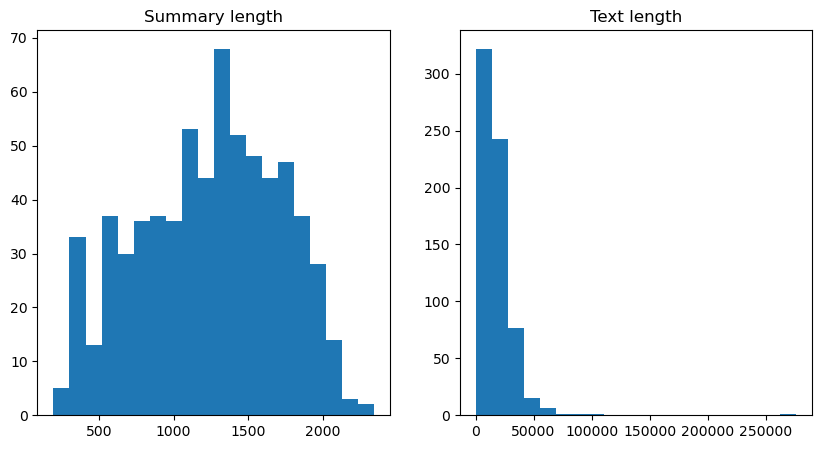

In [6]:
# Plot the length of each summary and of each text in two separate histograms as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist([len(x) for x in dataset['summary']], bins=20)
axs[0].set_title('Summary length')
axs[1].hist([len(x) for x in dataset['document']], bins=20)
axs[1].set_title('Text length')
plt.show()

### Prompt definitions:

Here we define some example prompts which we use for one-shot inference:

In [7]:
prompt_example_text = "The impact of climate change on global weather patterns has become increasingly evident in recent years, with more frequent and intense storms, heatwaves, and wildfires being reported across the world. Scientists warn that without immediate and concerted efforts to reduce greenhouse gas emissions and mitigate the effects of climate change, these extreme weather events will only become more severe, posing significant risks to human societies, economies, and ecosystems."
prompt_example_summary_one_sentence = "Climate change is causing more extreme weather events worldwide, and urgent action is needed to reduce greenhouse gas emissions and mitigate its impacts to prevent further escalation of risks to society, economies, and ecosystems."
prompt_example_summary_3_bullet = "Automation and AI advancements are transforming the job market, raising worries about job displacement. Proponents highlight the potential for increased productivity, innovation, and the emergence of new job sectors. Successful adaptation requires investment in retraining programs, lifelong learning, and supportive policies for workers transitioning to new roles."
prompt_example_text_10_percent = "In recent years, advances in renewable energy technologies have significantly expanded the options for generating clean and sustainable electricity. Solar photovoltaic (PV) panels, wind turbines, and hydroelectric power plants are among the most widely adopted renewable energy sources, offering environmentally friendly alternatives to fossil fuels. These technologies harness natural resources like sunlight, wind, and water to produce electricity without emitting greenhouse gases or other harmful pollutants. As a result, renewable energy has emerged as a key solution to mitigating climate change and reducing dependence on finite fossil fuel resources. Moreover, the declining costs of renewable energy systems have made them increasingly competitive with traditional energy sources, driving widespread adoption and investment in renewable energy infrastructure worldwide."
prompt_example_summary_10_percent = "Renewable energy technologies like solar, wind, and hydro are gaining traction as clean alternatives to fossil fuels, offering environmentally friendly electricity generation without greenhouse gas emissions."

In [8]:
prompts_before = [
                'Generate a summary 10 times shorter for the following text: ',
                'Generate a summary 20 times shorter for the following text: ',
                'Generate a summary 30 times shorter for the following text: ',
                'Generate a summary of lenght 50 words: ',
                'Generate a summary of lenght 75 words: ',
                'Generate a summary of lenght 100 words: ',
                'Generate a summary of lenght 125 words: ',
                'Generate a summary of lenght 150 words: ',
                'Generate a summary of lenght 175 words: ',
                'Generate a summary of lenght 200 words: ',
                'Summarise this text in 1 sentence: ',
                'Summarise this text in 5 sentences: ',
                'Summarise this text in 10 sentences: ',
                'Summarise this text in 3 bullet-points: ',
                'Summarise this text in 5 bullet-points: ',
                'Summarise this text in 10 bullet-points: ',
                'Summarise this text in 1 sentence.\n Text: ',
                'Summarise this text in 5 sentences.\n Text: ',
                'Summarise this text in 10 sentences.\n Text: ',
                ]

prompts_after = [' Summary: ',
                 ' Example summary: ',]

### Data Preprocessing:

Tokenization using nltk library:

In [9]:
# Tokenize the documents and summaries
nltk.download('punkt')
tokenized_dataframe = pd.DataFrame()
tokenized_dataframe['summary'] = dataset['summary'].apply(word_tokenize)
tokenized_dataframe['document'] = dataset['document'].apply(word_tokenize)
tokenized_dataframe['document_len'] = tokenized_dataframe['document'].apply(len)
tokenized_dataframe['original_summary'] = dataset['summary']
tokenized_dataframe['original_document'] = dataset['document']

tokenized_dataframe.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,summary,document,document_len,original_summary,original_document
0,"[we, determined, the, extent, and, distributio...","[survival, rates, continue, to, improve, with,...",2042,we determined the extent and distribution of c...,survival rates continue to improve with the ad...
1,"[methodsstudents, attending, five, different, ...","[for, every, living, creature, ,, elderliness,...",2535,methodsstudents attending five different types...,"for every living creature , elderliness is the..."
2,"[the, voltage, -, gated, k, channel, database,...","[voltage, -, gated, k, channels, (, vkcs, ), c...",2482,the voltage - gated k channel database ( vkcdb...,voltage - gated k channels ( vkcs ) constitute...
3,"[variations, in, quantity, and, quality, of, e...","[medicinal, plants, have, been, used, for, cen...",2561,variations in quantity and quality of essentia...,medicinal plants have been used for centuries ...
4,"[aim, ., acute, pancreatitis, is, an, inflamma...","[acute, pancreatitis, is, an, inflammatory, in...",3080,aim . acute pancreatitis is an inflammatory in...,acute pancreatitis is an inflammatory intra - ...


In [10]:
print("Number of documents: ", len(tokenized_dataframe))

Number of documents:  667


Filtering based on max context length for the model:

In [11]:
model_max_context_length = {"llama2-chat": 4096,
                            "notus-7b": 2048}
max_prompt_length = max([len(x) for x in prompts_before]) + max([len(x) for x in prompts_after])

In [12]:
model = "notus-7b"
max_context_length = model_max_context_length[model] - max_prompt_length

# Filter out documents that are too long
tokenized_dataframe = tokenized_dataframe[tokenized_dataframe['document_len'] <= max_context_length]

tokenized_dataframe.head()


,summary,document,document_len,original_summary,original_document
22,"[there, are, many, therapies, available, for, ...","[low, -, grade, lymphomas, are, chronic, disea...",1934,there are many therapies available for the man...,"low - grade lymphomas are chronic diseases , a..."
30,"[purpose, the, purpose, of, this, study, was, ...","[desktop, computer, and, laptop, use, is, beco...",1894,purpose the purpose of this study was to compa...,desktop computer and laptop use is becoming co...
34,"[background, :, varicose, vein, surgery, is, c...","[recurrence, has, been, attributed, to, neovas...",1875,background : varicose vein surgery is characte...,recurrence has been attributed to neovasculari...
47,"[neuroendocrine, tumors, are, a, heterogeneous...","[neuroendocrine, tumors, (, nets, ), comprise,...",1873,neuroendocrine tumors are a heterogeneous grou...,neuroendocrine tumors ( nets ) comprise a hete...
48,"[large, variation, in, assay, performance, and...","[in, the, aging, population, the, number, of, ...",1965,large variation in assay performance and outco...,in the aging population the number of alzheime...


In [13]:
print(f"Number of documents after filtering: {len(tokenized_dataframe)}")

Number of documents after filtering: 235


In [14]:
# remove from the dataframe rows in which the length of the summary is greater than the length of the document
def sanitize(df):
    df = df[df['original_summary'].apply(len) <= df['original_document'].apply(len)]
    return df 

In [15]:
tokenized_dataframe = sanitize(tokenized_dataframe)

print(f"Number of documents after sanitizing: {len(tokenized_dataframe)}")

Number of documents after sanitizing: 230


In [36]:
# This function is used to generate prompts for the model to generate an output on zero-shot inference
def prompt_creation_zero_shot(data, special_tokens, pb, pa, length_based=False):

    document = data['original_document']
    summary = data['original_summary']
    doc_len = data['document_len']
    if length_based:
        # Length-based prompts are used to generate summaries of different lengths = exln^2
        size = math.ceil(math.exp(1) * (math.pow(math.log(doc_len), 2)))
        text = f"Generate a summary of length {size}: "
        prompt = f"{special_tokens}{text}{document}{prompts_after[pa]}{special_tokens}"
        return {"prompt": prompt, "document": document, "summary": summary, "prompt_type": pb, "size": size}
    prompt = f"{special_tokens}{prompts_before[pb]}{document}{prompts_after[pa]}{special_tokens}"
    return {"prompt": prompt, "document": document, "summary": summary, "prompt_type": pb, "size": "na"}

def prompt_creation_one_shot(data, special_tokens, pa, ten_percent = False, one_sentence = False, three_bullet = False):
    document = data['original_document']
    if ten_percent:
        prompt = f"{special_tokens}{prompts_before[0]}{prompt_example_text_10_percent}{prompts_after[1]}{prompt_example_summary_10_percent}{prompts_before[0]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    if one_sentence:
        prompt = f"{special_tokens}{prompts_before[10]}{prompt_example_text}{prompts_after[1]}{prompt_example_summary_one_sentence}{prompts_before[10]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    if three_bullet:
        prompt = f"{special_tokens}{prompts_before[13]}{prompt_example_text}{prompts_after[1]}{prompt_example_summary_3_bullet}{prompts_before[13]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    return prompt

In [17]:
prompt_creation_zero_shot(tokenized_dataframe.iloc[0], "", 0, 0, length_based=False)

{'prompt': 'Generate a summary 10 times shorter for the following text: low - grade lymphomas are chronic diseases , and some patients may live for many years following initial diagnosis.1 therefore , for many patients it is currently regarded as appropriate not to treat immediately at diagnosis , but rather to watch and wait . once patients do require treatment , there are many therapies available : chemotherapeutic agents known to be effective in low - grade lymphoma include alkylating agents , anthracycline - based regimens , purine analogs , and bendamustine . in addition , there is the established monoclonal antibody therapy rituximab , and newer antibodies such as ofatumumab . patients may also undergo stem - cell transplantation either autologous or allogeneic with or without myeloablation preceding allogeneic transplantation . finally , there is currently a small amount of experience available on the use of techniques such as dna vaccination or antisense therapy . questions abo

In [28]:
prompt_creation_one_shot(tokenized_dataframe.iloc[0], "", 0, ten_percent=True, one_sentence=False, three_bullet=False)

'Generate a summary 10 times shorter for the following text: In recent years, advances in renewable energy technologies have significantly expanded the options for generating clean and sustainable electricity. Solar photovoltaic (PV) panels, wind turbines, and hydroelectric power plants are among the most widely adopted renewable energy sources, offering environmentally friendly alternatives to fossil fuels. These technologies harness natural resources like sunlight, wind, and water to produce electricity without emitting greenhouse gases or other harmful pollutants. As a result, renewable energy has emerged as a key solution to mitigating climate change and reducing dependence on finite fossil fuel resources. Moreover, the declining costs of renewable energy systems have made them increasingly competitive with traditional energy sources, driving widespread adoption and investment in renewable energy infrastructure worldwide. Example summary: Renewable energy technologies like solar, w

### Connection to WandB:

In [17]:
#wandb.login(key='YOUR_API_KEY')

In [18]:
run = wandb.init(project="table-test")
my_table = wandb.Table(columns=["Model", "Prompt", "Output", "Percent check", "Percent", "Words check", "Words", "Sentences check", "Sentences", "BART score"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cipdev16 (deep-mining-project). Use `wandb login --relogin` to force relogin


### Metric definitions:

We use simple criteria to assess the correctness of the generated summaries. Specifically, we use NLTK word_tokenize to check the number of predicted words and compare them with the instruction given.

In [ ]:
def percent_check(input, output, percent):
    tokenized_input = word_tokenize(input)
    tokenized_output = word_tokenize(output)
    if len(tokenized_output)*100/len(tokenized_input) <= percent + 3 and len(tokenized_output)*100/len(tokenized_input) >= percent - 3:
        return True, len(tokenized_output)*100/len(tokenized_input)
    return False, len(tokenized_output)*100/len(tokenized_input)

def length_check(output, length):
    tokenized_output = word_tokenize(output)
    if len(tokenized_output) <= length + 10 and len(tokenized_output) >= length + 10:
        return True, len(tokenized_output)
    return False, len(tokenized_output)

def sentence_check(output, sentence_length):
    # remove bullet points and new lines from the output
    output = output.replace("\n", "")
    regex = re.compile(r'^\d+\.\s*')
    print(output)
    tokenized_output = sent_tokenize(output)
    filtered = [i for i in tokenized_output if not regex.match(i)]
    if len(filtered) == sentence_length:
        return True, len(filtered)
    return False, len(filtered)

def bullet_check(output, bullet_length):
    tokenized_output = output.split("\n")
    # remove empty strings from the list
    tokenized_output = list(filter(None, tokenized_output))
    print(tokenized_output)
    if len(tokenized_output) == bullet_length:
        return True, len(tokenized_output)
    return False, len(tokenized_output)

Furthermore, we should also test the quality of the generated summaries. As we cannot rely on a target summary, we selected BARTScore to evaluate the factualness and semantic similarity of the predicted summary against the source document.

In [ ]:
from bart_score import BARTScorer

scorer = BARTScorer()
# scorer.load(path="bart_score.pth")

def calculate_bart_score(hypotheses, references):
    score = scorer.score(references, hypotheses)
    return score


In [ ]:
calculate_bart_score(["The quick brown fox jumps over the lazy dog"], ["The quick brown fox jumps over the lazy dog"])

[-1.0009068250656128]

### Testing setup: 

Here we define the testing setup for the experiment: what models we use, what prompts we use, and what documents we use.

In [38]:
# define random seed
seed = 42
np.random.seed(seed)

# choose n random documents from the dataset where n is the number of prompts
n = len(prompts_before)
random_docs = tokenized_dataframe.sample(n)

# create a list of prompts for zero-shot inference
zero_shot_prompts = []
for i in range(n):
    for j in range(len(prompts_after) - 1):
        zero_shot_prompts.append(prompt_creation_zero_shot(random_docs.iloc[i], "", i, j, length_based=False))
zero_shot_prompts.append(prompt_creation_zero_shot(random_docs.iloc[0], "", 0, 0, length_based=True))

# create a list of prompts for one-shot inference
one_shot_prompts = []
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, ten_percent=True, one_sentence=False, three_bullet=False))
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, ten_percent=False, one_sentence=True, three_bullet=False))
one_shot_prompts.append(prompt_creation_one_shot(random_docs.iloc[0], "", 0, ten_percent=False, one_sentence=False, three_bullet=True))

print("Zero-shot prompts: ", zero_shot_prompts)
print("One-shot prompts: ", one_shot_prompts)

culicoides spp . latreille ( diptera : ceratopogonidae ) or biting midges are small ( 0.5 - 2.0 mm in length ) bloodsucking insects that have a broad distribution and impact on human and veterinary health as vectors of viruses ( bluetongue , african horse sickness , epizootic hemorrhagic disease of deer , akabane , aino , chuzan , and bovine ephemeral fever viruses ) , protozoan parasites ( haemoproteus and leucocytozoon spp . ) , and filarial worms ( onchocerca and dipetalonema spp . ) throughout their range 1 - 15 . the first nationwide biting midge surveys in the republic of korea ( rok ) were reported in 1974 , with seasonal abundance and host blood meal analysis of culicoides spp . collected from cattle and poultry farms in gyeonggi - do ( province ) more recently , a brief summary of the history of research into the culicoides fauna and seasonal prevalence of culicoides spp . collected at 9 cowsheds in the southern part of the rok were reported by kim et al . along with new recor

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/notus-7B-v1-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-32g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

for i in range(len(one_shot_prompts)):
    prompt = one_shot_prompts[i]
    doc = random_docs.iloc[0]['original_document']
    summary = random_docs.iloc[0]['original_summary']
    prompt_template=f'''
    <|im_start|>user
    {prompt}<|im_end|>
    '''
    input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
    encoded_output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=model_max_context_length["notus-7b"])
    decoded_output = tokenizer.decode(encoded_output[0])
    print(decoded_output)
    output = decoded_output.split("|im_end|>")[1]
    output = output.split("</s>")[0]
    output = output.split("\n", 1)[1]
    if i == 0:
        check, percent = percent_check(doc, output, 10)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, check, percent, None, None, None, None, bart_score[0])
        continue

    if i == 1:
        check, words = sentence_check(output, 1)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, True, words, None, None, bart_score[0])
        continue

    if i == 2:
        check, words = bullet_check(output, 3)
        bart_score = calculate_bart_score([output], [summary])
        my_table.add_data(model_name_or_path, prompt, output, None, None, None, None, True, words, bart_score[0])
        continue

for i in range(2):
    prompt = zero_shot_prompts[i]["prompt"]
    prompt_type = zero_shot_prompts[i]["prompt_type"]
    size = zero_shot_prompts[i]["size"]
    document = zero_shot_prompts[i]["document"]
    summary = zero_shot_prompts[i]["summary"]
    assistant = "Write a concise summary of the provided text, adhering strictly to the specified length requirement and focusing solely on conveying the main points without additional elaboration or commentary."
    prompt_template=f'''<|system|>
    {assistant}
    <|im_start|>user
    {prompt}<|im_end|>
    '''
    input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
    encoded_output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=model_max_context_length["notus-7b"])
    decoded_output = tokenizer.decode(encoded_output[0])
    print(decoded_output)
    output = decoded_output.split("|im_end|>")[1]
    output = output.split("</s>")[0]
    output = output.split("\n", 1)[1]
    check, percent = percent_check(doc, output, (prompt_type + 1)*10)
    bart_score = calculate_bart_score([output], [summary])
    my_table.add_data(model_name_or_path, prompt, output, check, percent, None, None, None, None, bart_score[0])



run.log({"Table Name": my_table})